In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch

from datasets import load_dataset, Dataset, DatasetDict
from huggingface_hub import login
from peft import LoraConfig, get_peft_model
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling, pipeline

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [ ]:
TOKEN = 'TOKEN_HUGGING_FACE'
login(token=TOKEN)

In [ ]:
model_name = "Qwen/Qwen1.5-1.8B-Chat"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

# Data Preprocessing

In [ ]:
data = pd.read_excel('Data_Final.xlsx')
data = data.rename(columns={'Texto': 'text', 'Categoría de 1 a 5': 'label', 'Dataset': 'dataset'})
data = data[['text', 'label', 'dataset']]

data = data.dropna(subset=['label']).reset_index(drop=True)
data['label'] = data['label'].astype(int)

In [ ]:
def preprocessing(text):
    text = text.replace('\n', ' ')
    return text

data['text'] = data['text'].apply(preprocessing)

In [ ]:
data.head()

,text,label,dataset
0,"- ¡Rápido, necesitamos sangre! - Yo soy 0 posi...",4,test
1,- ¿Cuál es el mejor portero del mundial? - Ev...,3,train-val
2,El otro día unas chicas llamarón a mi puerta y...,3,test
3,"- Andresito, ¿qué planeta va después de Marte?...",4,train-val
4,- ¿Por qué Bob Esponja no va al gimnasio? - P...,1,train-val


In [ ]:
data.shape

(6012, 3)

In [ ]:
data['label'].value_counts()

,count
label,
3,2755
4,1413
2,1156
5,371
1,317


In [ ]:
data_train_val = data[data['dataset'] == 'train-val']

In [ ]:
data_train_val.shape

(4816, 3)

In [ ]:
print(f"If data_train_val is 90% of the data, then the total data must have {round(4816/0.9)} texts.")

If data_train_val is 90% of the data, then the total data must have 5351 texts.


In [ ]:
print(f"Test shape must be {round(5351 - 4816)} to be 10% of total data.")

Test shape must be 535 to be 10% of total data.


In [ ]:
# Dividir en train (80%), validación (10%) y test (10%)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data_train_val['text'], data_train_val['label'], test_size=0.111, random_state=42, stratify=data_train_val['label']
)

train_df = pd.DataFrame({'text': train_texts, 'label': train_labels})
val_df = pd.DataFrame({'text': val_texts, 'label': val_labels})

test_df = data[data['dataset'] == 'test'].drop(['dataset'], axis=1).sample(n=535, random_state=42)

In [ ]:
train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
val_dataset = Dataset.from_pandas(val_df, preserve_index=False)
test_dataset = Dataset.from_pandas(test_df, preserve_index=False)

dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 4281
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 535
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 535
    })
})


In [ ]:
def tokenize_function(example):
    return tokenizer(example['text'], truncation=True, max_length=256)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/4281 [00:00<?, ? examples/s]

Map:   0%|          | 0/535 [00:00<?, ? examples/s]

Map:   0%|          | 0/535 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 4281
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 535
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 535
    })
})

# Fine-Tuning

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
model = AutoModelForCausalLM.from_pretrained(model_name, num_labels=5, trust_remote_code=True).to(device)

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.67G [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


generation_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

In [ ]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_CLS"
)

model = get_peft_model(model, lora_config)

In [ ]:
training_args = TrainingArguments(
    output_dir="./qwen-finetuned-humor-multi",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=8,
    eval_strategy="epoch",
    warmup_steps=100,
    save_strategy="epoch",
    logging_steps=10,
    learning_rate=2e-4,
    save_total_limit=2,
    fp16=True,
    optim="adamw_torch",
    report_to="none"
)

In [ ]:
data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator
)

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
0,2.547200,2.627273
1,2.352700,2.554905
2,2.254800,2.544538


TrainOutput(global_step=801, training_loss=2.4817201415548906, metrics={'train_runtime': 1322.6289, 'train_samples_per_second': 9.71, 'train_steps_per_second': 0.606, 'total_flos': 1.3534605292756992e+16, 'train_loss': 2.4817201415548906, 'epoch': 2.9976646426903315})

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

model.save_pretrained("/content/drive/MyDrive/Archivos_MAIA/Proyecto_Final/qwen-humor-multi")
tokenizer.save_pretrained("/content/drive/MyDrive/Archivos_MAIA/Proyecto_Final/qwen-humor-multi")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


('/content/drive/MyDrive/Archivos_MAIA/Proyecto_Final/qwen-humor-multi/tokenizer_config.json',
 '/content/drive/MyDrive/Archivos_MAIA/Proyecto_Final/qwen-humor-multi/special_tokens_map.json',
 '/content/drive/MyDrive/Archivos_MAIA/Proyecto_Final/qwen-humor-multi/vocab.json',
 '/content/drive/MyDrive/Archivos_MAIA/Proyecto_Final/qwen-humor-multi/merges.txt',
 '/content/drive/MyDrive/Archivos_MAIA/Proyecto_Final/qwen-humor-multi/added_tokens.json',
 '/content/drive/MyDrive/Archivos_MAIA/Proyecto_Final/qwen-humor-multi/tokenizer.json')

In [ ]:
model.save_pretrained("./qwen-humor-multi")
tokenizer.save_pretrained("./qwen-humor-multi")

('./qwen-humor-multi/tokenizer_config.json',
 './qwen-humor-multi/special_tokens_map.json',
 './qwen-humor-multi/vocab.json',
 './qwen-humor-multi/merges.txt',
 './qwen-humor-multi/added_tokens.json',
 './qwen-humor-multi/tokenizer.json')

# Load Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_path = "/content/drive/MyDrive/Archivos_MAIA/Proyecto_Final/qwen-humor-multi"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_path, trust_remote_code=True)

generator = pipeline("text-generation", model=model, tokenizer=tokenizer, device_map="auto")

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.67G [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


generation_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
prompt = "Cuéntame un chiste:"
output = generator(prompt, max_new_tokens=50, do_sample=True)

In [ ]:
print(output[0]["generated_text"])

Cuéntame un chiste: ¿Por qué los chistes nunca se hacen en la escuela? Porque el único que llega al final son los humoristas con el cuaderno en blanco. ¡El éxito sigue sin llegar! ¡Como si pudiera dejar a las


In [ ]:
data_test = test_df.copy()
data_test = data_test.reset_index(drop=True)

In [ ]:
data_test.head()

,text,label
0,"Vaun vasco por la calle con su hijo, los dos a...",3
1,Dos borrachos que están en la plaza del pueblo...,4
2,Un borracho va cantando a gritos por la calle ...,4
3,Hay 3 tipos de personas: las que saben contar ...,1
4,- ¡Alto! Se ha saltado un semáforo en rojo. Te...,3


In [ ]:
def predict_score(texts):
    predictions = []
    for i, text in enumerate(texts):
        prompt = f"Asigna un puntaje entre 1 y 5 dependiendo del nivel de gracia causado por el siguiente texto, donde 1 es bajo y 5 es alto, retorna únicamente el puntaje:\n{text}\nPuntaje de 1 a 5: "
        prediction = generator(prompt, max_new_tokens=1, do_sample=True)[0]['generated_text'][-1]
        predictions.append(prediction)
        if (i + 1) % 10 == 0 or (i + 1) == len(texts):
            print(f"Classified texts: {i+1}/{len(texts)}")
    return predictions

In [ ]:
pred_scores = predict_score(data_test['text'])

Classified texts: 10/535
Classified texts: 20/535
Classified texts: 30/535
Classified texts: 40/535
Classified texts: 50/535
Classified texts: 60/535
Classified texts: 70/535
Classified texts: 80/535
Classified texts: 90/535
Classified texts: 100/535
Classified texts: 110/535
Classified texts: 120/535
Classified texts: 130/535
Classified texts: 140/535
Classified texts: 150/535
Classified texts: 160/535
Classified texts: 170/535
Classified texts: 180/535
Classified texts: 190/535
Classified texts: 200/535
Classified texts: 210/535
Classified texts: 220/535
Classified texts: 230/535
Classified texts: 240/535
Classified texts: 250/535
Classified texts: 260/535
Classified texts: 270/535
Classified texts: 280/535
Classified texts: 290/535
Classified texts: 300/535
Classified texts: 310/535
Classified texts: 320/535
Classified texts: 330/535
Classified texts: 340/535
Classified texts: 350/535
Classified texts: 360/535
Classified texts: 370/535
Classified texts: 380/535
Classified texts: 390

In [ ]:
pred_scores = ['1' if x in [' ', '0'] else x for x in pred_scores]

In [ ]:
pred_scores_int = list(map(int, pred_scores))

In [ ]:
len(pred_scores_int)

535

In [ ]:
test_scores = data_test['label'].tolist()

In [ ]:
len(test_scores)

535

In [ ]:
print(classification_report(test_scores, pred_scores_int))

              precision    recall  f1-score   support

           1       0.10      0.26      0.14        54
           2       0.19      0.36      0.25        86
           3       0.35      0.16      0.22       201
           4       0.32      0.24      0.27       178
           5       0.00      0.00      0.00        16

    accuracy                           0.22       535
   macro avg       0.19      0.20      0.18       535
weighted avg       0.28      0.22      0.23       535



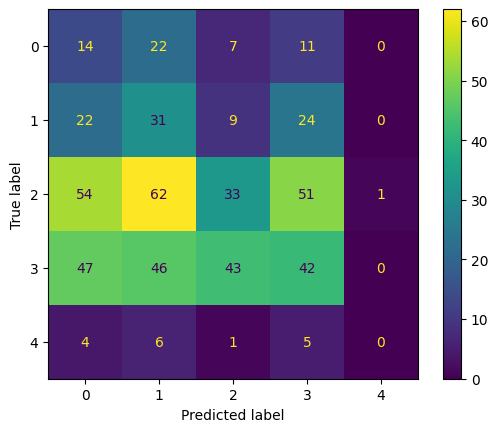

In [ ]:
cm = confusion_matrix(test_scores, pred_scores_int)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()